In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras
from sklearn.preprocessing import StandardScaler, PowerTransformer, MaxAbsScaler, Normalizer, RobustScaler, minmax_scale, QuantileTransformer

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [181]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [182]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [129]:
symbols = trainSet.ticker.unique()

In [185]:
symbols[:100]

array(['A', 'AA', 'AABA', 'AAL', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP',
       'AAPL', 'AAT', 'AAV', 'AAWW', 'AAXJ', 'AAXN', 'AB', 'ABAC', 'ABAX',
       'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCD', 'ABDC', 'ABEO', 'ABEV',
       'ABG', 'ABIL', 'ABIO', 'ABM', 'ABMD', 'ABR', 'ABT', 'ABTX', 'ABUS',
       'ABX', 'AC', 'ACAD', 'ACBI', 'ACC', 'ACCO', 'ACER', 'ACET', 'ACGL',
       'ACGLO', 'ACGLP', 'ACH', 'ACHC', 'ACHN', 'ACHV', 'ACIA', 'ACIU',
       'ACIW', 'ACLS', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACOR', 'ACP',
       'ACRE', 'ACRS', 'ACRX', 'ACSF', 'ACST', 'ACT', 'ACTG', 'ACWI',
       'ACWX', 'ACXM', 'ADAP', 'ADBE', 'ADC', 'ADES', 'ADI', 'ADM',
       'ADMA', 'ADMP', 'ADMS', 'ADNT', 'ADOM', 'ADP', 'ADRA', 'ADRD',
       'ADRE', 'ADRO', 'ADRU', 'ADS', 'ADSK', 'ADSW', 'ADTN', 'ADUS',
       'ADVM', 'ADX', 'ADXS', 'AEB', 'AED', 'AEE', 'AEG', 'AEGN'],
      dtype=object)

In [242]:
timesteps = 60
def make_samples(
    data_1,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [243]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['y'][i] = []
    
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']]
    # Apply moving average 
    mv_rate = 20
    data_1 = data_1.rolling(mv_rate).mean().values
    data_1 = data_1[mv_rate-1:]
 
    make_samples(
        data_1, 
        s)
    
    if s == 'AEGN':
        break

In [244]:
for s in train_set:
    for i in train_set[s]['y']:
        x_1 = train_set[s]['x_1'][i]
        y = train_set[s]['y'][i]
        train_set[s]['x_1'][i] = np.array(x_1)
        train_set[s]['y'][i] = np.array(y)

In [245]:
train_set['AAPL']['x_1'][1].shape

(676, 60, 1)

In [246]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [247]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(1,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [248]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(61611, 1, 60) (61611,)
Fitting prediction interval 1  model
Train on 43127 samples, validate on 18484 samples
Epoch 1/100
43127/43127 [==============================] - 4s 98us/step - loss: 0.2450 - val_loss: 0.0852
Epoch 2/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.1089 - val_loss: 0.0515
Epoch 3/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.0791 - val_loss: 0.0389
Epoch 4/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.0633 - val_loss: 0.0295
Epoch 5/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.0529 - val_loss: 0.0253
Epoch 6/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.0431 - val_loss: 0.0209
Epoch 7/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.0387 - val_loss: 0.0184
Epoch 8/100
43127/43127 [==============================] - 0s 2us/step - loss: 0.0336 - val_loss: 0.0153
Epoch 9/100
43127/43127 [=======================

42510/42510 [==============================] - 0s 2us/step - loss: 0.0648 - val_loss: 0.0564
Epoch 14/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0633 - val_loss: 0.0548
Epoch 15/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0615 - val_loss: 0.0538
Epoch 16/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0612 - val_loss: 0.0540
Epoch 17/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0593 - val_loss: 0.0543
Epoch 18/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0598 - val_loss: 0.0511
Epoch 19/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0587 - val_loss: 0.0507
Epoch 20/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0568 - val_loss: 0.0518
Epoch 21/100
42510/42510 [==============================] - 0s 2us/step - loss: 0.0579 - val_loss: 0.0488
Epoch 22/100
42510/42510 [==============================] -

In [249]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [250]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [251]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']]
    data_1 = data_1.rolling(mv_rate).mean().values
    data_1 = data_1[mv_rate-1:]
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)

                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [252]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

In [253]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 0.4813149415723218
Test Set -> MSE of AAPL inveral 3: 1.9421150631743502
Test Set -> MSE of AAPL inveral 5: 5.842767084186289
Test Set -> MSE of AAPL inveral 10: 11.775008199200176


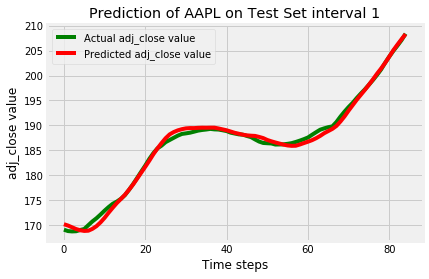

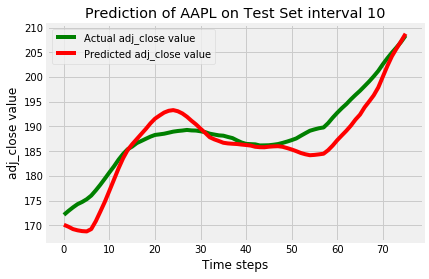

In [254]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 10 symbols

In [255]:
test_symbols = ['A','AAPL','ABAX','ACIU','ADUS']

In [256]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [257]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 3))
    all_mse_10.append(round(all_mse[s][10], 3))

In [258]:
all_mse_1

[0.06, 0.481, 0.3, 0.075, 0.219]

In [259]:
all_mse_10

[0.831, 11.775, 3.573, 1.186, 3.347]

In [263]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 3)))

MSE of Interval 10 = 13.85 Interval 1
MSE of Interval 10 = 24.48 Interval 1
MSE of Interval 10 = 11.91 Interval 1
MSE of Interval 10 = 15.813 Interval 1
MSE of Interval 10 = 15.283 Interval 1
